# Setup

In [1]:
!pip install ultralytics > /dev/null
!pip install git+https://github.com/openai/CLIP.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-d5vmsgja


In [ ]:
# Unzip the training results - NOT NEEDED AFTER GIT CLONE
!unzip -q trained_models.zip -d trained_models

!cd trained_models && for f in *.zip; do \
    dirname="${f%.zip}"; \
    mkdir -p "$dirname"; \
    unzip -q "$f" -d "$dirname"; \
done


In [1]:
import os, glob, random, numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

from datasets import CUHK03PairDataset, MarketPairDataset, make_feature_datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from training import evaluate
from pretrained_models_features_extractors import make_extractor
from comparator_models import make_comparator

# Reproducibility
SEED = 17
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print("Device:", device)

os.makedirs("outputs/training_results", exist_ok=True)

Device: cpu


Loading the models after the training process

In [2]:
MODELS_DIR = "./trained_models"

checkpoints = []
for path in glob.glob(os.path.join(MODELS_DIR, "**", "*.pt"), recursive=True):
    ckpt = torch.load(path, map_location="cpu")
    checkpoints.append(ckpt)

print(f"Loaded {len(checkpoints)} checkpoints")

Loaded 32 checkpoints


# Show training stats

Training results

In [3]:
rows = []
for ckpt in checkpoints:
    rows.append({
        "extractor": ckpt["extractor_name"],
        "comparator": ckpt["comparator_name"],
        "best_epoch": ckpt["best_epoch"],
        "best_val_loss": ckpt["best_val_loss"],
        "path": f"{ckpt['extractor_name']}_{ckpt['comparator_name']}.pt"
    })

results_df = pd.DataFrame(rows)

# sort by models 
results_df.sort_values(["extractor","comparator"], inplace=True)
results_df.to_csv("outputs/training_results/val_losses_by_model.csv", index=False)

# sort by val loss
results_df.sort_values("best_val_loss", inplace=True)
results_df.to_csv("outputs/training_results/val_losses_sorted.csv", index=False)

results_df



,extractor,comparator,best_epoch,best_val_loss,path
8,dinov2_vits,attention,3,0.471483,dinov2_vits_attention.pt
10,dinov2_vits,lowrank_bilinear,16,0.505438,dinov2_vits_lowrank_bilinear.pt
14,efficientnet_b0,lowrank_bilinear,15,0.506141,efficientnet_b0_lowrank_bilinear.pt
0,clip,attention,5,0.512442,clip_attention.pt
20,resnet50,attention,3,0.515578,resnet50_attention.pt
6,densenet121,lowrank_bilinear,22,0.518827,densenet121_lowrank_bilinear.pt
12,efficientnet_b0,attention,3,0.519054,efficientnet_b0_attention.pt
11,dinov2_vits,mlp,9,0.522604,dinov2_vits_mlp.pt
2,clip,lowrank_bilinear,25,0.522807,clip_lowrank_bilinear.pt
4,densenet121,attention,1,0.528183,densenet121_attention.pt


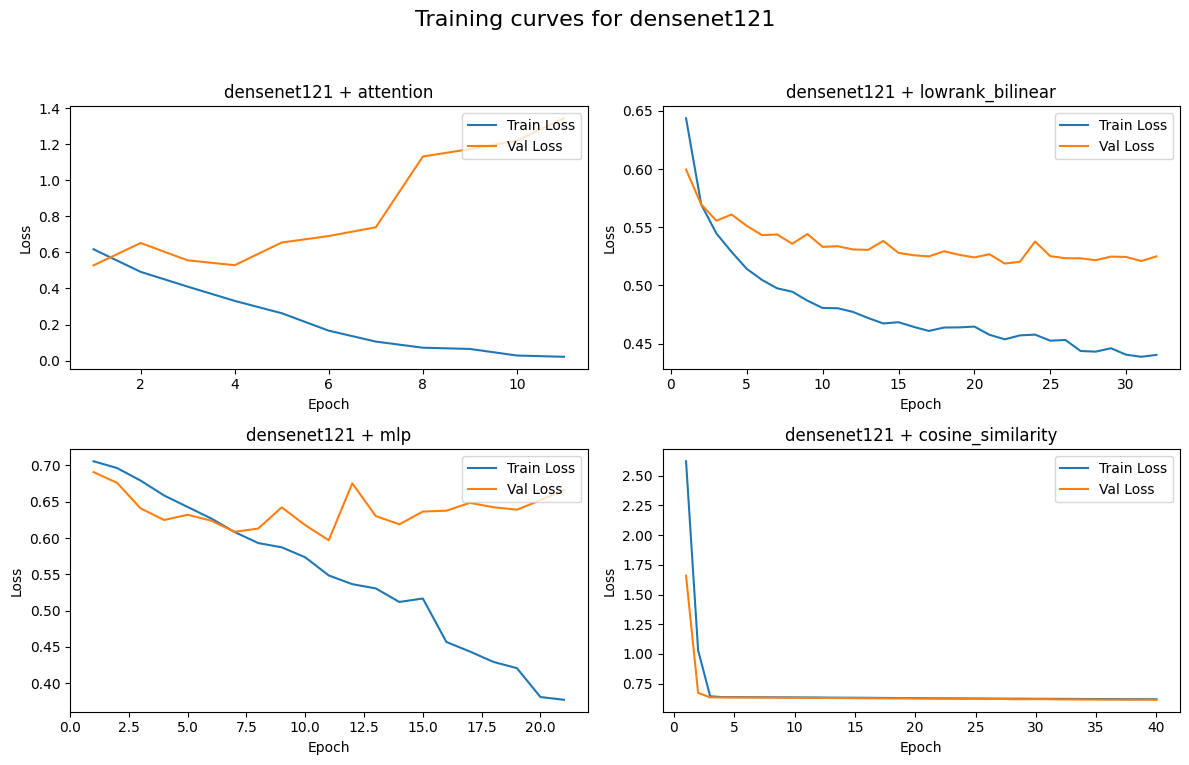

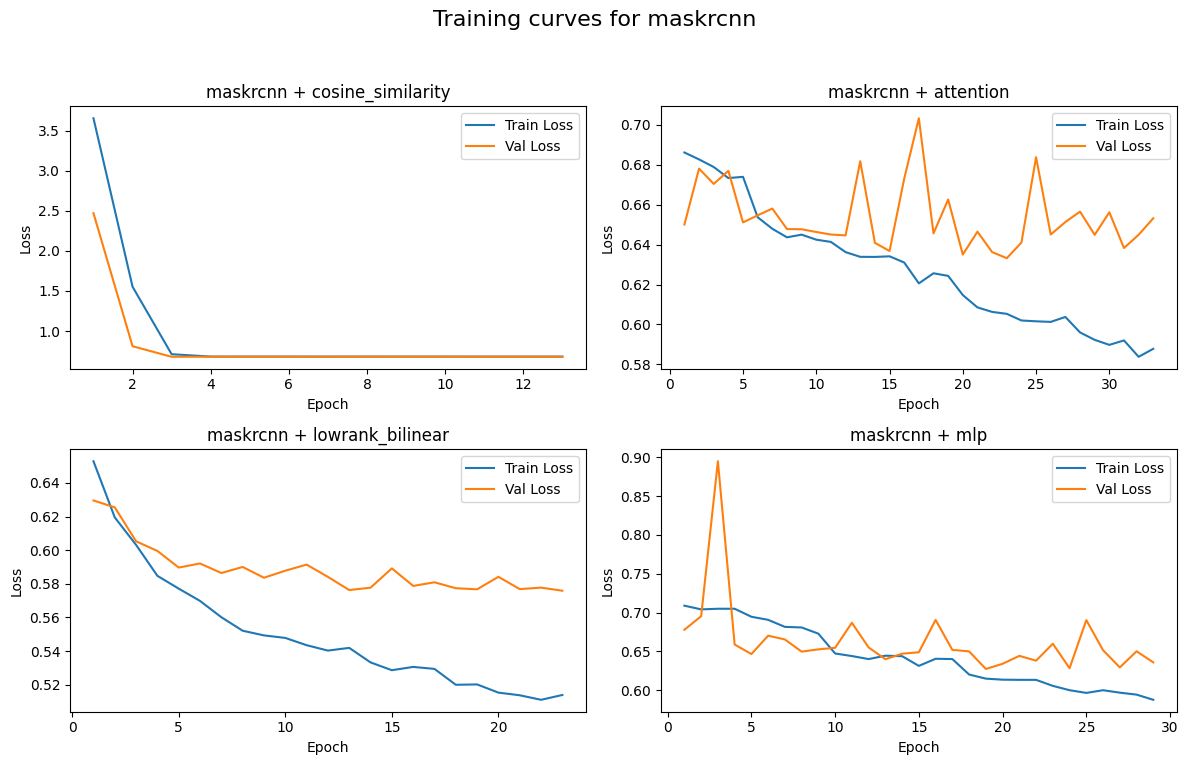

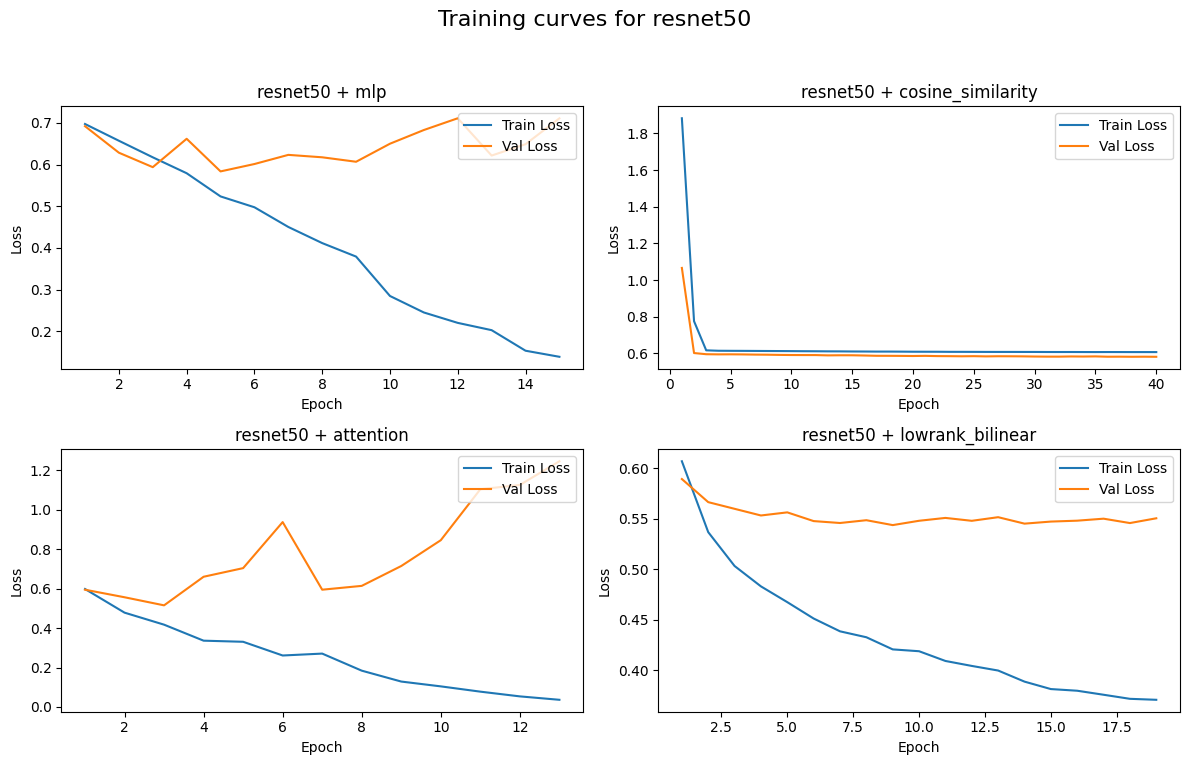

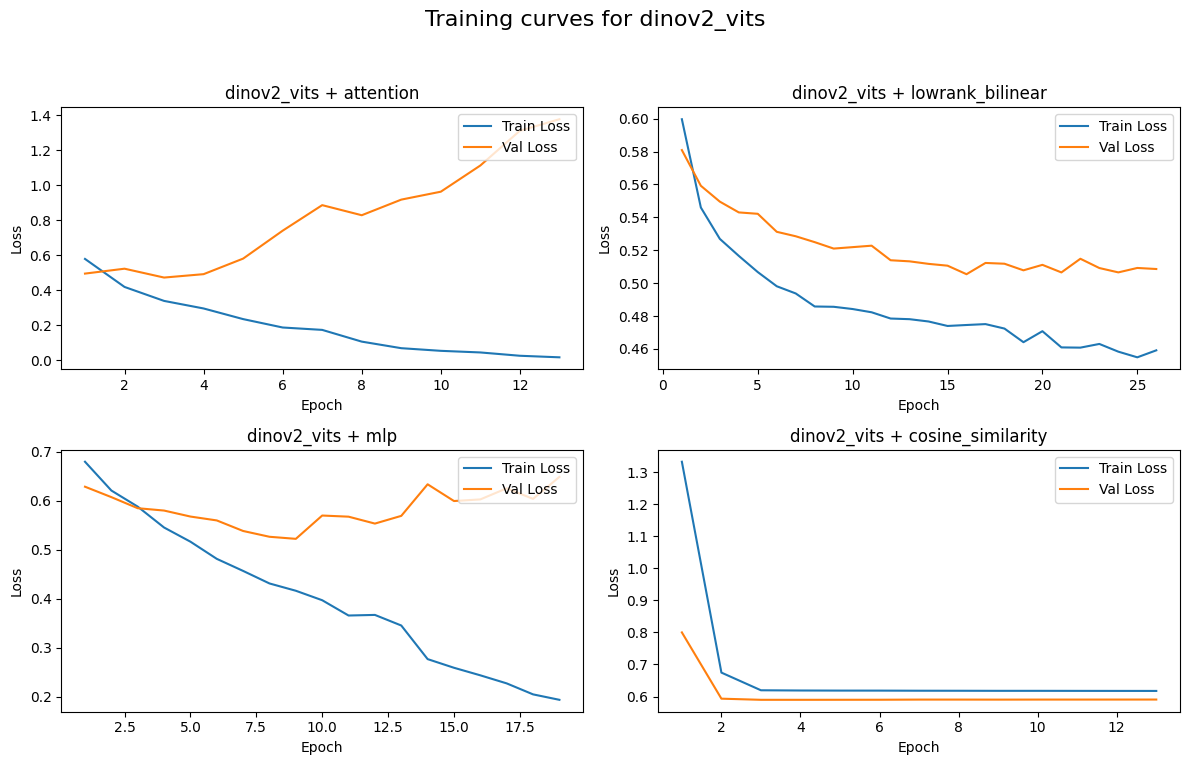

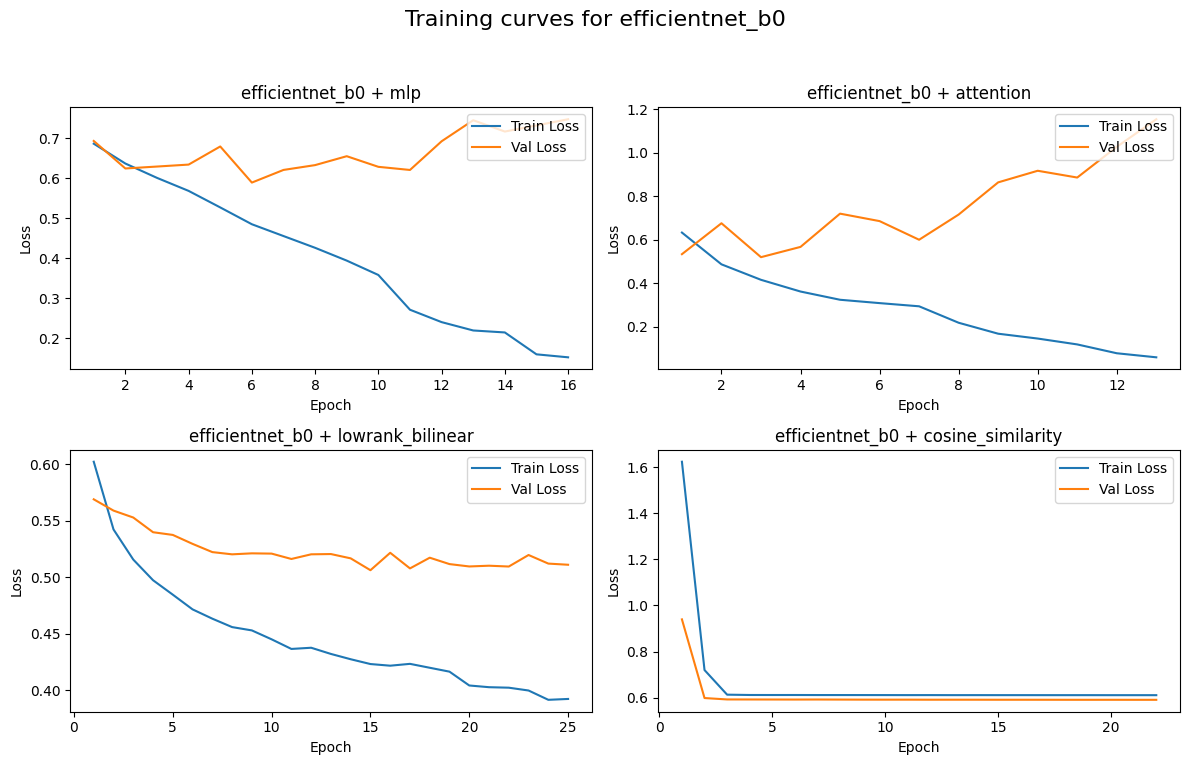

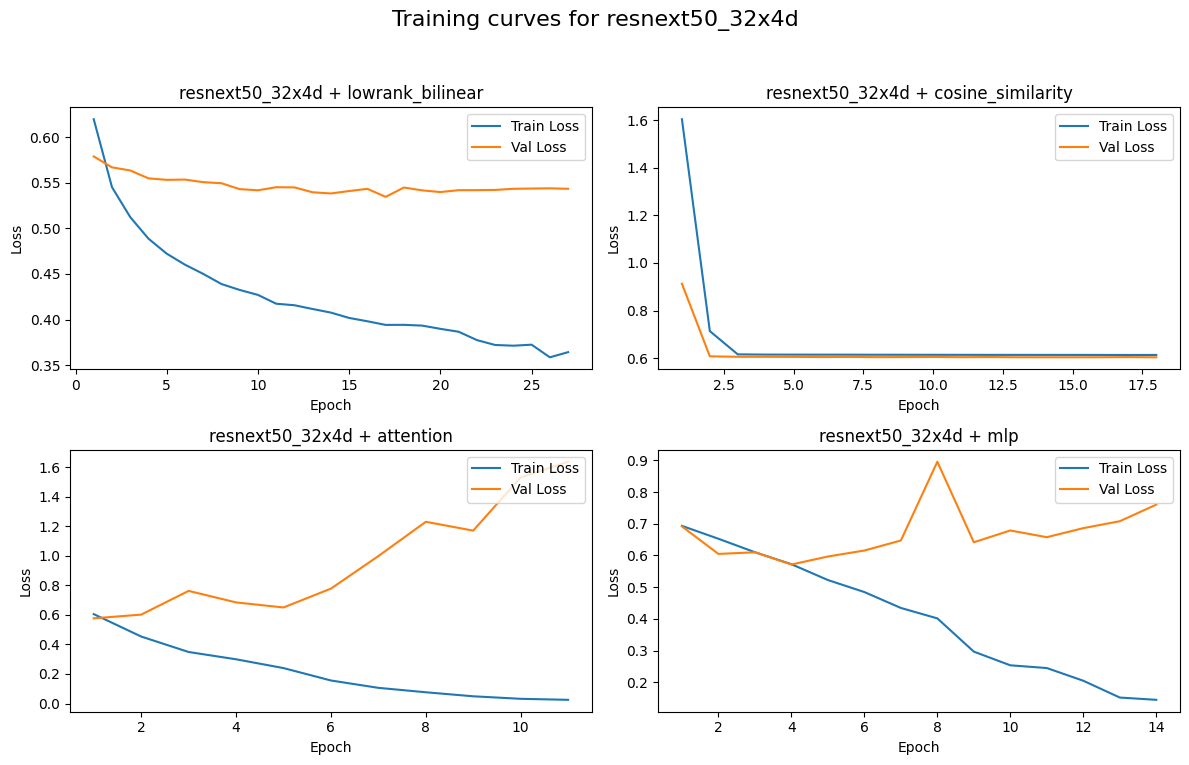

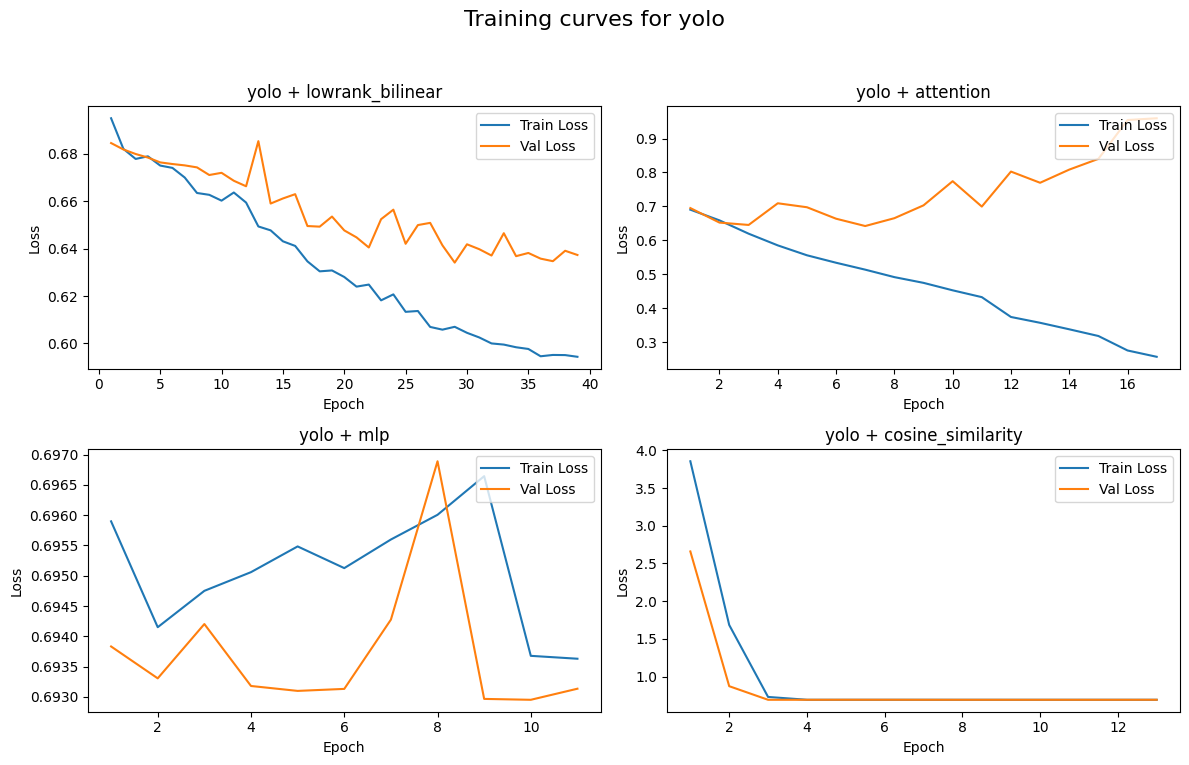

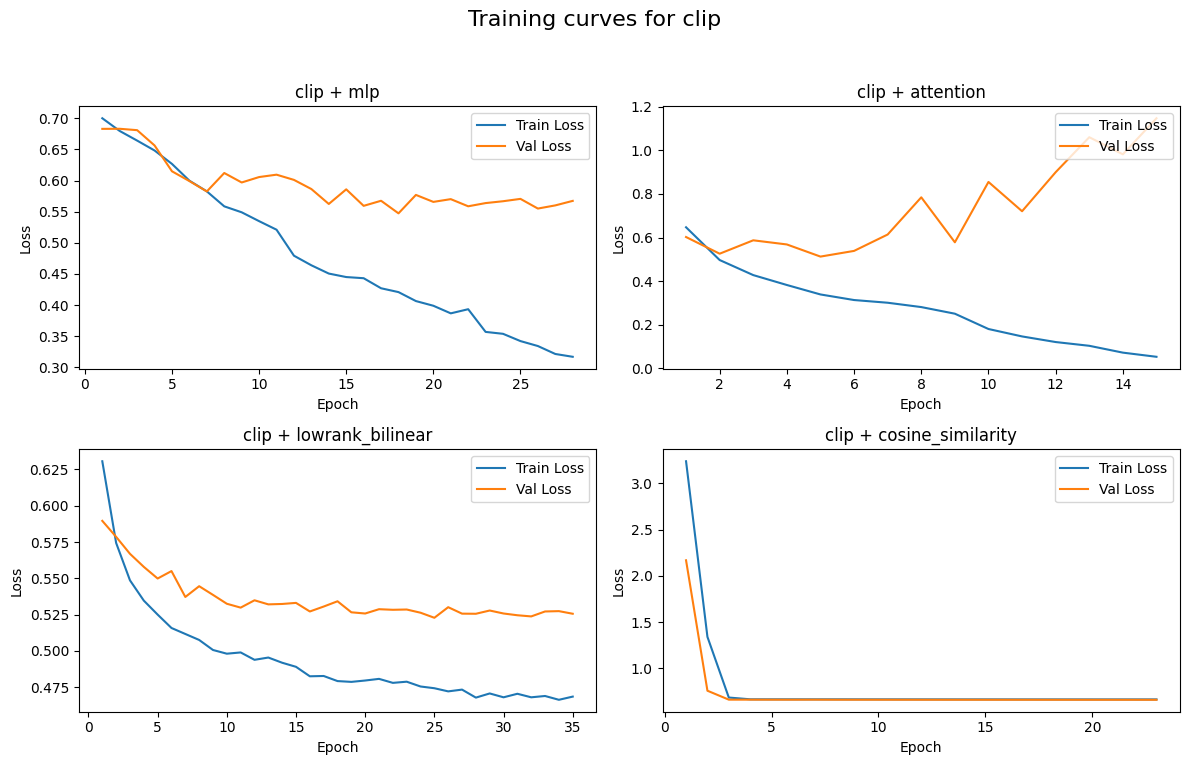

In [ ]:
# group checkpoints by extractor
from collections import defaultdict
extractor_groups = defaultdict(list)
for ckpt in checkpoints:
    extractor_groups[ckpt["extractor_name"]].append(ckpt)

# plot
for extractor, ckpts in extractor_groups.items():
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for ax, ckpt in zip(axes, ckpts):
        hist = ckpt["history"]
        comparator = ckpt["comparator_name"]
        xs = list(range(1, len(hist["train_losses"]) + 1))

        # train + val loss
        ax.plot(xs, hist["train_losses"], label="Train Loss")
        ax.plot(xs, hist["val_losses"], label="Val Loss")

        ax.set_title(f"{extractor} + {comparator}")
        ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
        ax.legend(loc="upper right")

    fig.suptitle(f"Training curves for {extractor}", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f"outputs/training_results/{extractor}.png", dpi=150)
    plt.show()


# Conclusions - find the best model and check on test sets

Find the best model based on val loss

In [4]:
# Find the best checkpoint
best_row = results_df.loc[results_df["best_val_loss"].idxmin()]
print("Best overall model:")
print(best_row)

Best overall model:
extractor                     dinov2_vits
comparator                      attention
best_epoch                              3
best_val_loss                    0.471483
path             dinov2_vits_attention.pt
Name: 8, dtype: object


In [ ]:
# pull extractor + comparator names
best_extractor = best_row["extractor"]
best_comparator = best_row["comparator"]
path_to_pt = f"trained_models/{best_extractor}/{best_extractor}_{best_comparator}/CUHK03_{best_extractor}_{best_comparator}.pt"
best_checkpoint = torch.load(path_to_pt)

# create the extractor
extractor = make_extractor(best_extractor, device)

# load the comparator
comparator = make_comparator(best_comparator, device)
comparator.load_state_dict(best_checkpoint['comparator_state'])

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

c:\Users\avive\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\avive\.cache\huggingface\hub\models--timm--vit_small_patch14_dinov2.lvd142m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


<All keys matched successfully>

In [11]:
# get the model size
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Freeze extractor
for p in extractor.parameters():
    p.requires_grad = False

# Count
ext_total, ext_train = count_parameters(extractor)
comp_total, comp_train = count_parameters(comparator)

print(f"Extractor (DINOv2): total={ext_total/1e6:.2f}M, trainable={ext_train/1e6:.2f}M")
print(f"Comparator (Attention): total={comp_total/1e6:.2f}M, trainable={comp_train/1e6:.2f}M")
print(f"Overall trainable parameters: {(ext_train+comp_train)/1e6:.2f}M")


Extractor (DINOv2): total=22.06M, trainable=0.00M
Comparator (Attention): total=0.30M, trainable=0.30M
Overall trainable parameters: 0.30M


## Download and deal with the datasets

In [ ]:
# CUHK03
!git clone https://github.com/manideep2510/CUHK03_dataset.git

# Market
!gdown --id 0B8-rUzbwVRk0c054eEozWG9COHM -O Market-1501-v15.09.15.zip
!unzip Market-1501-v15.09.15.zip > /dev/null

Cloning into 'CUHK03_dataset'...
remote: Enumerating objects: 33345, done.
remote: Total 33345 (delta 0), reused 0 (delta 0), pack-reused 33345 (from 1)
Receiving objects: 100% (33345/33345), 336.68 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (35659/35659), done.
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0B8-rUzbwVRk0c054eEozWG9COHM
From (redirected): https://drive.google.com/uc?id=0B8-rUzbwVRk0c054eEozWG9COHM&confirm=t&uuid=41277490-c830-43d7-bb94-88ea48295ec6
To: /content/Market-1501-v15.09.15.zip
100% 153M/153M [00:03<00:00, 50.4MB/s]


In [30]:
CUHK03_DATASET = "./CUHK03_dataset/detected/"
CUHK03_TRAIN_DIR = CUHK03_DATASET + "/train_resized"
CUHK03_VAL_DIR   = CUHK03_DATASET + "/val_resized"

MARKET_DATASET = "./Market-1501-v15.09.15/bounding_box_train"

# How many images to pair per image in the dataset
PAIRS_PER_IMAGE = 10

In [ ]:
# Load val set
cuhk03_val_full = CUHK03PairDataset(CUHK03_VAL_DIR, num_pairs_per_id=PAIRS_PER_IMAGE)

# Split the "val" folder into actual val + test
VAL_RATIO = 0.5   # 50% val, 50% test
n_val = int(len(cuhk03_val_full) * VAL_RATIO)
n_test = len(cuhk03_val_full) - n_val

cuhk03_val, cuhk03_test = random_split(
    cuhk03_val_full,
    [n_val, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

# Wrap into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

cuhk03_val_loader = DataLoader(
    cuhk03_val, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)

cuhk03_test_loader = DataLoader(
    cuhk03_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)

# Market: Will be used for evaluation only - i.e all the set is a test set
market_test = MarketPairDataset(MARKET_DATASET, num_pairs_per_id=PAIRS_PER_IMAGE)
market_test_loader = DataLoader(
    market_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)

print("CUHK03 -> val/test batches:", len(cuhk03_val_loader), len(cuhk03_test_loader))
print("Market -> total eval batches:", len(market_test_loader))


CUHK03 -> val/test batches: 16 16
Market -> total eval batches: 235


Viewing the datasets

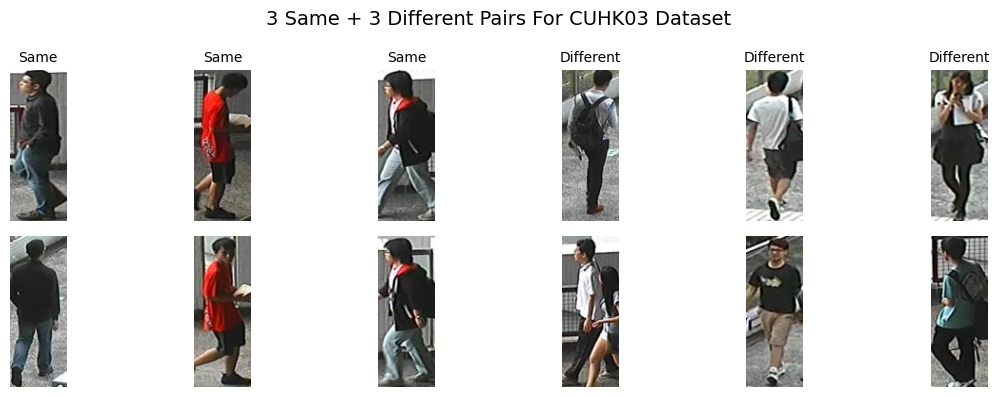

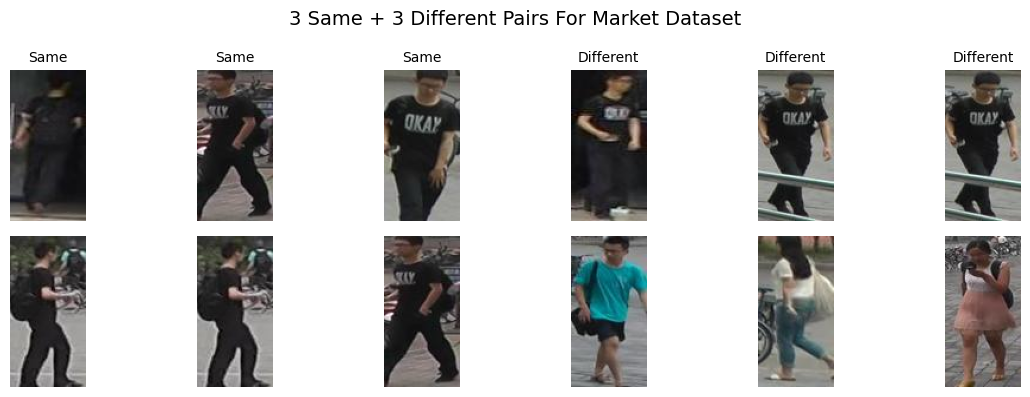

In [36]:
import matplotlib.pyplot as plt

for dataset_name, dataset_loader in zip(["CUHK03", "Market"], [cuhk03_val_loader, market_test_loader]):
  # Grab a batch
  img1, img2, labels = next(iter(dataset_loader))

  # Select 3 same and 3 different
  same_idx = (labels == 1).nonzero(as_tuple=True)[0][:3]
  diff_idx = (labels == 0).nonzero(as_tuple=True)[0][:3]

  pairs = [(img1[i], img2[i], "Same") for i in same_idx] + \
          [(img1[i], img2[i], "Different") for i in diff_idx]

  # Plot: 2 rows × 6 columns
  fig, axes = plt.subplots(2, len(pairs), figsize=(2*len(pairs), 4))
  for c, (a, b, lbl) in enumerate(pairs):
      axes[0, c].imshow(a.permute(1,2,0).clamp(0,1))
      axes[0, c].axis("off")
      axes[1, c].imshow(b.permute(1,2,0).clamp(0,1))
      axes[1, c].axis("off")
      axes[0, c].set_title(lbl, fontsize=10)

  plt.suptitle("3 Same + 3 Different Pairs For "+dataset_name+" Dataset", fontsize=14)
  plt.tight_layout()
  plt.show()


In [39]:
# Precompute dataset in feature space
cuhk03_val_features_dataset = make_feature_datasets(cuhk03_val, extractor, device)
cuhk03_test_features_dataset = make_feature_datasets(cuhk03_test, extractor, device)
market_test_features_dataset = make_feature_datasets(market_test, extractor, device)

cuhk03_features_val_loader = DataLoader(
    cuhk03_val_features_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

cuhk03_features_test_loader = DataLoader(
    cuhk03_test_features_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

market_features_test_loader = DataLoader(
    market_test_features_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

Processing:   0%|          | 0/63 [00:00<?, ?it/s]

Processing:   0%|          | 0/63 [00:00<?, ?it/s]

Processing:   0%|          | 0/939 [00:00<?, ?it/s]

## THE RESULTS

In [64]:
cuhk03_val_loss, cuhk03_val_acc = evaluate(extractor, comparator, cuhk03_features_val_loader, device)
print(f"CUHK03 Validation -> loss: {cuhk03_val_loss:.4f}, acc: {cuhk03_val_acc:.3f}")

cuhk03_test_loss, cuhk03_test_acc = evaluate(extractor, comparator, cuhk03_features_test_loader, device)
print(f"CUHK03 Test -> loss: {cuhk03_test_loss:.4f}, acc: {cuhk03_test_acc:.3f}")

market_test_loss, market_test_acc = evaluate(extractor, comparator, market_features_test_loader, device)
print(f"Market Test -> loss: {market_test_loss:.4f}, acc: {market_test_acc:.3f}")

CUHK03 Validation -> loss: 0.4800, acc: 0.784
CUHK03 Test -> loss: 0.4404, acc: 0.790
Market Test -> loss: 0.6344, acc: 0.679


Taking a small sample and testing the model on

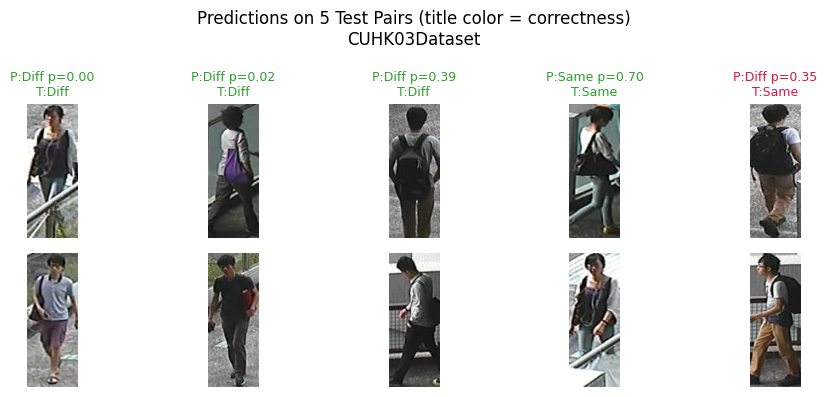

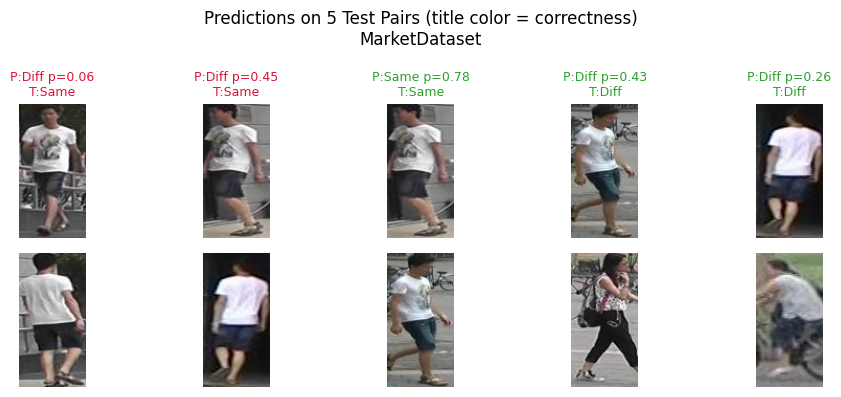

In [65]:
for dataset_name, dataset_loader in zip(["CUHK03", "Market"], [cuhk03_test_loader, market_test_loader]):
    # pick a random index inside the dataset
    n_batches = len(dataset_loader)

    skip = random.randint(0, max(0, len(dataset_loader)-1))
    for i, batch in enumerate(dataset_loader):
        if i == skip:
            img1, img2, labels = batch
            break

    # Predict with current model
    extractor.eval(); comparator.eval()
    with torch.no_grad():
        f1, f2 = extractor(img1.to(device)), extractor(img2.to(device))
        f1 = F.normalize(f1, dim=1).float()
        f2 = F.normalize(f2, dim=1).float()
        probs = torch.sigmoid(comparator(f1, f2)).cpu()

    preds = (probs >= 0.5).int()
    gt    = labels.int()

    # Plot 2 rows × 5 cols with true labels and correctness coloring
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        ok = bool(preds[i] == gt[i])
        color = "tab:green" if ok else "crimson"
        axes[0, i].imshow(img1[i].permute(1,2,0).clamp(0,1)); axes[0, i].axis("off")
        axes[1, i].imshow(img2[i].permute(1,2,0).clamp(0,1)); axes[1, i].axis("off")
        p_lbl  = "Same" if preds[i] else "Diff"
        gt_lbl = "Same" if gt[i] else "Diff"
        axes[0, i].set_title(f"P:{p_lbl} p={probs[i]:.2f}\nT:{gt_lbl}", fontsize=9, color=color)

    plt.suptitle("Predictions on 5 Test Pairs (title color = correctness)\n"+dataset_name + "Dataset")
    plt.tight_layout()
    fig.savefig(f"outputs/predictions_on_{dataset_name}_test_set.png", dpi=150)
    plt.show()


In [66]:
# Save the outputs folder as zip for easy download
! zip -r outputs.zip outputs/

  adding: outputs/ (stored 0%)
  adding: outputs/predictions_on_CUHK03_test_set.png (deflated 2%)
  adding: outputs/training_results/ (stored 0%)
  adding: outputs/training_results/clip.png (deflated 9%)
  adding: outputs/training_results/efficientnet_b0.png (deflated 9%)
  adding: outputs/training_results/resnet50.png (deflated 10%)
  adding: outputs/training_results/resnext50_32x4d.png (deflated 10%)
  adding: outputs/training_results/train_losses.csv (deflated 67%)
  adding: outputs/training_results/maskrcnn.png (deflated 8%)
  adding: outputs/training_results/dinov2_vits.png (deflated 10%)
  adding: outputs/training_results/densenet121.png (deflated 9%)
  adding: outputs/training_results/yolo.png (deflated 8%)
  adding: outputs/predictions_on_Market_test_set.png (deflated 2%)
